In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'handwritten-characters:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F53376%2F101598%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240620%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240620T193810Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D102ee0945e01ca00bd292dad7c5d14d01dc1a599bcb1ed51bc0046a7f393bc27387bada1edd37ebd335bf3bb7b8cfc81e570feb495eea88438e362510e1a2705af573c8dbea66b32694b610ff851119f614a69df42628a94877b120248b3f470fb1465574118d47d1963221307e8af1bb0cd3a580019a307929ee664ef33ec6b9e7de738239e6688a195771a64ca041aec7a5855be7089ba8e2acc0ba6749962a516f2905e587e0f8213dd8b33e2351d36d06caa2dd327acefa21c73c558cd39ea4bc3dbab499c1ce002ce92a62f042ef9d4acee8d166467afab9cb886c064ef6bcf6bf643c2ffce26fae4ed66a6734f3849c49311dab3637c937092beb5e457,handwriting-recognition:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F818027%2F1400106%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240620%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240620T193810Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5b5abd12819a47f4f205ded6d2a5c89bf7f4ee48709f8fdd7a58bae65ea0935a347c51f49ffdcabe7964ad47dfa88d967b950797149cabb51bd60e0990241960849ebbe9e5021e1c6155fb238e041df5dcc87da9659b71009eac6b03a102efb5bf6ee35ab38dae8f2db1f03905c90cfccfe5a5e8d77bf60c34cdb5bb5a7f0df66affb907375a72a1ce34c2ed6f8e7da29ddb477b7abf784e1d43801d4af32c4cd1a483ea137327a8b0fda0a9fe20fe04683524a8cd216289322c1b3bf8c7aa04572531e1e05f6a2556e7d36303846aeea1a2d54cb6afce9e6baed126015b3a9b956a7c52c1b9da99e91033bc769f7c8e41362de1802559565388a8cd26a8698c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1740501298 bytes downloaded
Downloaded and uncompressed: handwritten-characters
[==================================================] 1353071625 bytes downloaded
Downloaded and uncompressed: handwriting-recognition
Data source import complete.


# *Offline Handwritten Text Recognition*

### The purpose of this notebook is to give a brief idea and a basic approach for offline handwritten text recognition by using segmentation and classification.

## What is Offline Handwritten Text Recognition?
Offline handwriting recognition involves the automatic conversion of text in an image into letter codes that are usable within computer and text-processing applications. In simple terms, it is the text extraction from your handwritten notebooks/pages. Why called offline? The point being that there is an online text recognition system, which is referred for text that is digitally generated by using tools like stylus, apple pencil, etc.

## Approach

* **Step1** :  Build a digit(0-9) + A-Z characters classifier using a CNN architecture.
* **Step2** :  Apply character segmentation for the handwritten word image.
* **Step3** :  Classify each segmented letter and then get the final word in the image.

In [2]:
!pip install imutils

In [3]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import os
import random
import cv2
import imutils
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
# Instead of keras.utils import np_utils use the below import
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import LabelBinarizer
from keras import backend as K
from keras.layers import Dense, Activation, Flatten, Dense,MaxPooling2D, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

In [4]:
dir = "../input/handwritten-characters/Train/"
train_data = []
img_size = 32
non_chars = ["#","$","&","@"]
for i in os.listdir(dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 4000:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        train_data.append([img,i])

In [5]:
len(train_data)

140000

In [6]:
val_dir = "../input/handwritten-characters/Validation/"
val_data = []
img_size = 32
for i in os.listdir(val_dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(val_dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 1000:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        val_data.append([img,i])

In [7]:
len(val_data)

15209

In [8]:
random.shuffle(train_data)
random.shuffle(val_data)

In [9]:
train_X = []
train_Y = []
for features,label in train_data:
    train_X.append(features)
    train_Y.append(label)

In [10]:
val_X = []
val_Y = []
for features,label in val_data:
    val_X.append(features)
    val_Y.append(label)

In [11]:
LB = LabelBinarizer()
train_Y = LB.fit_transform(train_Y)
val_Y = LB.fit_transform(val_Y)

In [12]:
train_X = np.array(train_X)/255.0
train_X = train_X.reshape(-1,32,32,1)
train_Y = np.array(train_Y)

In [13]:
val_X = np.array(val_X)/255.0
val_X = val_X.reshape(-1,32,32,1)
val_Y = np.array(val_Y)

In [14]:
print(train_X.shape,val_X.shape)

(140000, 32, 32, 1) (15209, 32, 32, 1)


In [15]:
print(train_Y.shape,val_Y.shape)

(140000, 35) (15209, 35)


In [16]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(32,32,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(35, activation='softmax'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 128)         0

In [18]:
model.compile(loss='categorical_crossentropy', optimizer="adam",metrics=['accuracy'])

In [19]:
history = model.fit(train_X,train_Y, epochs=5, batch_size=32, validation_data = (val_X, val_Y),  verbose=1)

Epoch 1/5
4375/4375 [==============================] - 254s 58ms/step - loss: 0.6202 - accuracy: 0.8019 - val_loss: 0.3170 - val_accuracy: 0.8945
Epoch 2/5
4375/4375 [==============================] - 234s 53ms/step - loss: 0.3436 - accuracy: 0.8828 - val_loss: 0.2739 - val_accuracy: 0.9072
Epoch 3/5
4375/4375 [==============================] - 237s 54ms/step - loss: 0.3005 - accuracy: 0.8972 - val_loss: 0.2541 - val_accuracy: 0.9124
Epoch 4/5
4375/4375 [==============================] - 241s 55ms/step - loss: 0.2753 - accuracy: 0.9044 - val_loss: 0.2622 - val_accuracy: 0.8995
Epoch 5/5
4375/4375 [==============================] - 230s 53ms/step - loss: 0.2580 - accuracy: 0.9103 - val_loss: 0.2565 - val_accuracy: 0.9065


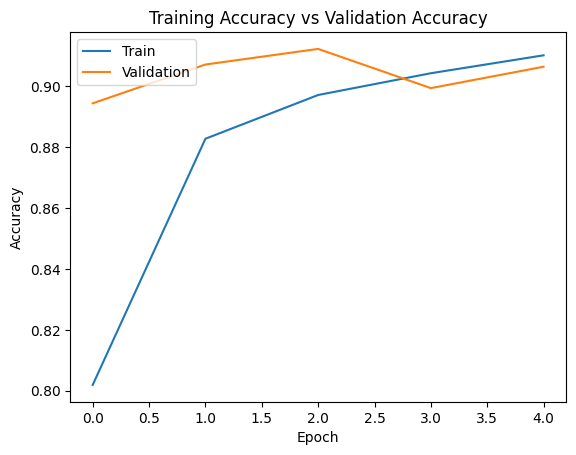

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

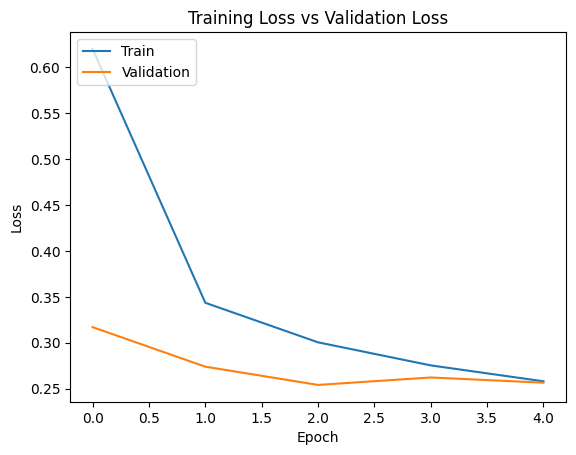

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Recognition and Post-Processing
1. The sort contours function is used to get the correct order of individual characters for correct output extraction. In this case for extracting a single word, a left to right sorting of individual characters is needed.
2. The get letters function fetches the list of letters and get word function gets the individual word.

In [22]:
# Define functions
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return (cnts, boundingBoxes)

In [23]:
def get_letters(img_path, threshold_level=127, dilate_iter=2):
    letters = []
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh1 = cv2.threshold(gray, threshold_level, 255, cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=dilate_iter)
    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]

    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            roi = gray[y:y + h, x:x + w]
            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            thresh = cv2.resize(thresh, (32, 32), interpolation=cv2.INTER_CUBIC)
            thresh = thresh.astype("float32") / 255.0
            thresh = np.expand_dims(thresh, axis=-1)
            thresh = thresh.reshape(1, 32, 32, 1)
            ypred = model.predict(thresh)
            ypred = LB.inverse_transform(ypred)
            [x] = ypred
            letters.append(x)

    return letters, image

In [24]:
def get_word(letters):
    return "".join(letters)

1/1 [==============================] - 0s 21ms/step
BENES


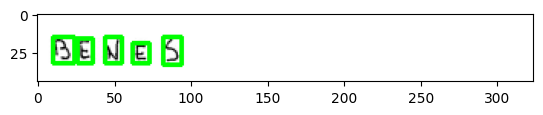

In [25]:
letter,image = get_letters("../input/handwriting-recognition/train_v2/train/TRAIN_00003.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

1/1 [==============================] - 0s 31ms/step
LIL0U


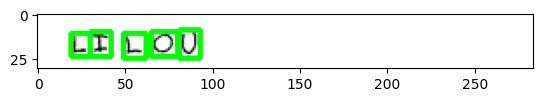

In [26]:
letter,image = get_letters("../input/handwriting-recognition/train_v2/train/TRAIN_00023.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

1/1 [==============================] - 0s 29ms/step
JAFFELX


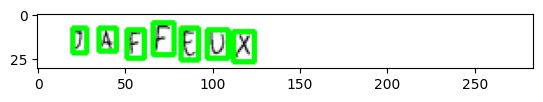

In [27]:
letter,image = get_letters("../input/handwriting-recognition/train_v2/train/TRAIN_00030.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

1/1 [==============================] - 0s 23ms/step
RUPP


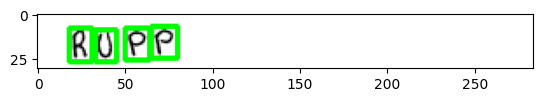

In [28]:
letter,image = get_letters("../input/handwriting-recognition/validation_v2/validation/VALIDATION_0005.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

In [3]:
# Install required packages
!pip install flask flask-cors pyngrok

from flask import Flask, request, jsonify
from flask_cors import CORS
from pyngrok import ngrok  # Import ngrok module

app = Flask(__name__)
CORS(app)

@app.route('/predict', methods=['POST'])
def predict():
    if 'file' not in request.files:
        return jsonify({"error": "No file part"}), 400

    file = request.files['file']

    if file.filename == '':
        return jsonify({"error": "No selected file"}), 400

    if file:
        try:
            from PIL import Image
            import pytesseract

            image = Image.open(file)
            text = pytesseract.image_to_string(image)
            return jsonify({"result": text})
        except Exception as e:
            print(f"Error processing image: {str(e)}")
            return jsonify({"error": "Failed to process the image"}), 500

    return jsonify({"error": "Unexpected error"}), 500

if __name__ == "__main__":
    public_url = ngrok.connect(5000)  # Expose Flask app on port 5000
    print(f"Your public URL is: {public_url}")

    app.run(host='0.0.0.0', port=5000)


Your public URL is: NgrokTunnel: "https://e1a2-35-201-130-77.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [21/Jun/2024 09:36:06] "POST /predict HTTP/1.1" 500 -


Error processing image: No module named 'pytesseract'


In [ ]:
# Install pytesseract and Tesseract-OCR
!pip install pytesseract
!apt-get update
!apt-get install -y tesseract-ocr
!apt-get install -y libtesseract-dev

# Import necessary libraries
from flask import Flask, request, jsonify
from flask_cors import CORS
from werkzeug.utils import secure_filename
import os
from PIL import Image
import pytesseract

app = Flask(__name__)
CORS(app)

@app.route('/predict', methods=['POST'])
def predict():
    if 'file' not in request.files:
        return jsonify({"error": "No file part"}), 400

    file = request.files['file']

    if file.filename == '':
        return jsonify({"error": "No selected file"}), 400

    if file:
        try:
            filename = secure_filename(file.filename)
            file_path = os.path.join("/tmp", filename)
            file.save(file_path)

            image = Image.open(file_path)
            text = pytesseract.image_to_string(image)
            os.remove(file_path)  # Clean up the file after processing

            return jsonify({"result": text})
        except Exception as e:
            print(f"Error processing image: {str(e)}")
            return jsonify({"error": f"Failed to process the image: {str(e)}"}), 500

    return jsonify({"error": "Unexpected error"}), 500

if __name__ == "__main__":
    from pyngrok import ngrok
    public_url = ngrok.connect(5000)
    print(f"Your public URL is: {public_url}")
    app.run(host='0.0.0.0', port=5000)


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [929 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,474 kB]
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [2,552 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.

INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [21/Jun/2024 09:45:32] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Jun/2024 09:48:13] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Jun/2024 10:11:50] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Jun/2024 10:12:00] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Jun/2024 10:12:11] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Jun/2024 10:12:19] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Jun/2024 10:13:14] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Jun/2024 10:13:32] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Jun/2024 10:13:44] "POST /predic

## Drawbacks
1. The recognition part is dependent on the contour detection code, so if the opencv library is not able to find the character contour, then this method will fail.
2. There could be a lot of variation in a single handwritten letter in terms of writing style, therefore a lot more examples are needed for training this model.
3. This model will not work for connected texts like a cursive handwritten word.

## Conclusion
This notebook is an illustration of how a character segmentation and classification approach can be used for offline handwritten text extraction. In order to improve the model, the model should be trained on the complete dataset, this notebook was trained on slightly less number of images due to session constraints. Also, for applying this method to a complete paragraph, following approach can be used, **line segmentation >> word segmentation >> character segmentation >> classification >> post-processing**.

## References
1. [https://www.pyimagesearch.com/2020/08/24/ocr-handwriting-recognition-with-opencv-keras-and-tensorflow/](http://)
2. [https://www.pyimagesearch.com/2015/04/20/sorting-contours-using-python-and-opencv/](http://)

If you liked this notebook, then do **Upvote** as it will keep me motivated in creating such kernels ahead. **Thanks!!**